# Analysis of the Professional Counter Strike Global Offensive Circuit
### CMSC 320 Final Project
### Richard Chen
___

## Introduction and Motivation
____
![](https://seeklogo.com/images/C/csgo-logo-CAA0A4D48A-seeklogo.com.png)


Counter-Strike Global Offensive (CS:GO) is a competitive PC game developed by Valve Corporation in 2012. It is part of a franchise of games stretching back to the release of the first Counter-Strike in 2000. CS:GO is played in a first person perspective, in which two teams of 5 players compete to see who wins a total of 16 rounds the fastest. For the first 15 rounds of the game, one side will play an offensive side (T-side) that is tasked with planting and bomb and having it detonate. The other side is tasked with defusing the bomb or preventing it from being planted at all (CT-side). Both teams can also win the round by eliminating all enemy players. In case both teams draw at the 30th round on 15-15, 6 more rounds are added as overtime; ends if a team wins 4 out of 6 rounds. At any point, there are 7 active maps in the competitive pool. Overall matches are played in a **best of 3 maps** to see who wins the series overall.

Because of the competitive nature of the game, a professional circuit has thrived over the past 8 years. With record player numbers in the base game (1.1 million concurrent players), and increased investment from traditional North American sports franchises, such as the Dallas Cowboys, CS:GO might be a sneak preview into the **future of entertainment**. Having a predictive model of how a competitive CS:GO team can be successful could be worth **millions** as the industry becomes more mainstream. Success in this model could open more opportunities for the broader sport of esports. 

In this tutorial, I will be analyzing a dataset from Kaggle Datasets. I will be going step-by-step through the data pipeline of professional CS:GO teams to determine winning trends and strategies. My goal is to lay the framework and an example for others to build upon when analyzing a competitive multiplayer game. This tutorial and analysis will be written with Python 3 in mind.

## Dataset
___

The dataset used for this tutorial analysis was found via Kaggle Datasets and can be found [here.](https://www.kaggle.com/mateusdmachado/csgo-professional-matches) Once you download the files from the link, you should find 4 csv files that stores the data we're interested in. This dataset includes data about competitive CS:GO matches between November 2015 to March 2020. The original source where the data was originally scraped from was www.hltv.org.

 - Results.csv: stores data about map scores and team rankings
 - Picks.csv: stores data about team's map picks and vetos during the prematch selection between opposing teams
 - Economy.csv: stores data about round start equipment values for all rounds played
 - Players.csv: stores individual performances of professional players on each map

## Getting Started
___

First we'll need to import and import the following python libraries: 
 - [Pandas](https://pandas.pydata.org/)
 - [Beautiful Soup (OPTIONAL)](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
 - [Matplotlib Pyplot](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.html)
 - [Seaborn](https://seaborn.pydata.org/)

The syntax to install the libraries is "pip install < library name >"


In [13]:
# Importing the required libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Data Scraping
___
Because the author of the CS:GO Kaggle dataset already scrapped the data off www.hltv.org, I will not be explicitly showing the steps needed to perform that. However, more information can be found by exploring documentation of **Beautiful Soup**, a Python library used to get data and parse a HTML page. [Link here to explore Beautiful Soup.](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

## Data Tidying
____
After the data is scrapped, I use the **Pandas library's read_csv function** to load it into a a data structure called a "DataFrame." This will allow me to easily manipulate rows and columns based on their values. A DataFrame will be the basis of making our data usable for the rest of the pipeline. Essentially one row will represent one matchup between teams.

In [2]:
# loading data from our data into a dataframe
df = pd.read_csv("./csgo-professional-matches/results.csv")
# displaying the first few items of our datafram
df.head()

date               team_1          team_2     _map  result_1  \
0  2020-03-18              Recon 5         TeamOne    Dust2         0   
1  2020-03-18              Recon 5         TeamOne  Inferno        13   
2  2020-03-18  New England Whalers        Station7  Inferno        12   
3  2020-03-18              Rugratz  Bad News Bears  Inferno         7   
4  2020-03-18              Rugratz  Bad News Bears  Vertigo         8   

   result_2  map_winner  starting_ct  ct_1  t_2  t_1  ct_2  event_id  \
0        16           2            2     0    1    0    15      5151   
1        16           2            2     8    6    5    10      5151   
2        16           2            1     9    6    3    10      5243   
3        16           2            2     0    8    7     8      5151   
4        16           2            2     4    5    4    11      5151   

   match_id  rank_1  rank_2  map_wins_1  map_wins_2  match_winner  
0   2340454      62      63           0           2             2  
1   2340454      62      63           0           2             2  
2   2340461     140     118          12          16             2  
3   2340453      61      38           0           2             2  
4   2340453      61      38           0           2             2

At this point, we will use functions within the Pandas library to make our DataFrame more usable. One of which is to eliminate excessive data that we will not use in our analysis moving forward. For example in this CS:GO case, we will eliminate matches that did not feature top 10 teams. We will also drop columns that will not be helpful moving forward.

### Functions used here:
 - **df = df.drop('column_name',1)** 
     - will be used to delete 'column_name' in a Pandas DataFrame. 1 is the axis number (0 for rows and 1 for columns).
 - **df = df.loc[df['column_name']...]** 
     - this will be used to filter the DataFrame based on the value of column_name. Could use any boolean statement of comparison in the "..." part 
 - **df['column_name'] = df.apply(lambda row: .... if ... else ...,axis =1)** 
     - this is the syntax used to create a new column based on already existing values of a particular row
 - **df.rename(index = str, columns = {"old_column_name": "new_column_name", ....}, inplace = True)** 
     - this can be used to rename columns and make it more presentable for the data pipeline further down
 - **df['date'] = pd.to_datetime(df['date'])** 
     - can be used to convert a column into a datetime object
 - **df = df_reset_index(drop = True)** 
     - can be used to reset the index

In [3]:
# cleaning up data
df = df.drop('starting_ct',1)
df = df.drop('result_1',1)
df = df.drop('result_2',1)
df = df.drop('map_wins_1',1)
df = df.drop('map_wins_2',1)
df = df.drop('event_id',1)
df = df.loc[df['rank_1'] <= 10]
df = df.loc[df['rank_2'] <= 10]

df['MapWinner'] = df.apply(lambda row: row.team_2 if row.map_winner == 2 else row.team_1, axis = 1)
df['SeriesWinner'] = df.apply(lambda row: row.team_2 if row.match_winner == 2 else row.team_1, axis = 1)
df['date'] = pd.to_datetime(df['date'])
df['Year'] = df.apply(lambda row: row.date.year, axis = 1)
df = df.loc[df['Year'] == 2018]
df = df.drop('date',1)

df = df.drop('map_winner',1)
df = df.drop('match_winner',1)
df.rename(columns = {'_map':'Map','team_1':'Team_One','team_2':'Team_Two','rank_1':'Team_Ones_Rank','rank_2': 'Team_Twos_Rank', \
                    'ct_1': 'Team_One_CT_Rounds','t_2': 'Team_Two_T_Rounds', 't_1':'Team_One_T_Rounds', 'ct_2':'Team_Two_CT_Rounds'}, inplace = True)
df = df.sort_values(by = 'match_id', ascending = False)
df = df.reset_index(drop = True)
df.head()

Team_One       Team_Two       Map  Team_One_CT_Rounds  Team_Two_T_Rounds  \
0  Astralis  Natus Vincere     Dust2                  12                  3   
1  Astralis  Natus Vincere  Overpass                   4                 11   
2  Astralis  Natus Vincere     Cache                  10                  5   
3      MIBR  Natus Vincere    Mirage                   3                  0   
4      FaZe            NiP   Inferno                  10                  5   

   Team_One_T_Rounds  Team_Two_CT_Rounds  match_id  Team_Ones_Rank  \
0                  4                   1   2329728               1   
1                  3                   5   2329728               1   
2                  6                   4   2329728               1   
3                 13                   2   2329723               4   
4                  5                  10   2329722               5   

   Team_Twos_Rank      MapWinner SeriesWinner  Year  
0               3       Astralis     Astralis  2018  
1               3  Natus Vincere     Astralis  2018  
2               3       Astralis     Astralis  2018  
3               3           MIBR         MIBR  2018  
4               7            NiP          NiP  2018

## Entity Resolution
___
Potential issue that might arise when using multiple datasets; for example, if the data scientist wanted to use data from Players.csv. I will now show an example of **joining** two DataFrames together. If the question was: "I want to see how this individual player performs when his team wins vs how this player performs when his team loses" In order to analyze such a question, you would join the data on match_id. I have performed this below as well as cleanup the player dataset. I have consolidated and averaged data from a player's matchups for each map.

Functions used here:
 - **df = df[['...']]**
     - will be used to specify the columns we want to keep from the original dataframe
 - **df['...'] = df[['...']].mean(axis=1)**
     - will be used to create a new column from data kept in other columns. In this case, it's averaging data from the other columns

In [4]:
# cleaning up the player data
player_df = pd.read_csv("./csgo-professional-matches/players.csv")
player_df = player_df[['player_name','team', 'match_id', 'm1_rating_ct', 'm1_rating_t', 'm2_rating_ct', \
                       'm2_rating_t','m3_rating_ct', 'm3_rating_t']]
player_df = player_df.dropna(subset=['m1_rating_ct', 'm1_rating_t', 'm2_rating_ct','m2_rating_t'])
player_df['Average_T_Rating'] = player_df[['m1_rating_t', 'm2_rating_t', 'm3_rating_t']].mean(axis=1)
player_df['Average_CT_Rating'] = player_df[['m1_rating_ct', 'm2_rating_ct', 'm3_rating_ct']].mean(axis=1)
player_df = player_df.drop(['m1_rating_ct','m1_rating_t', 'm2_rating_ct','m2_rating_t','m3_rating_ct',\
                            'm3_rating_t'],1)
player_df.rename(columns = {'player_name': 'Player', 'team': 'Team'}, inplace = True)
player_df.head()

Player           Team  match_id  Average_T_Rating  Average_CT_Rating
0  Brehze  Evil Geniuses   2339385          0.860000           1.080000
1    CeRq  Evil Geniuses   2339385          0.676667           1.150000
2   EliGE         Liquid   2339385          0.876667           1.486667
3   Ethan  Evil Geniuses   2339385          0.413333           1.096667
4     NAF         Liquid   2339385          0.876667           1.273333

My dataframe here has been transformed so now each row reflects a player's performance during a match.

Functions used here:
 - **new_df = pd.merge(temp_df,df,on = 'col_name')**
     - will be used to join dataframes together,in this setup, you'll be joining temp_df and df on the column name. By default this is a inner join, so only data that has a perfect match on this identification column will be kept in the final dataframe.
 - **new_df = new_df.sort_values(by = 'col_name', ascending = False)**
     - will be used to sort rows by the value of a column

In [5]:
# creating a new dataframe by merging
new_df = pd.merge(player_df,df,on = 'match_id')
new_df = new_df.sort_values(by = 'match_id', ascending = False)
new_df = new_df.reset_index(drop = True)
new_df = new_df.drop('match_id',1)
new_df = new_df.drop('Year',1)
new_df = new_df.loc[new_df['Team'] != 'Renegades']
new_df = new_df.loc[new_df['Team'] != 'North']
new_df = new_df.loc[new_df['Team'] != 'NiP']
new_df = new_df.loc[new_df['Team'] != 'Gambit']
new_df = new_df.loc[new_df['Team'] != 'BIG']
new_df = new_df.loc[new_df['Team'] != 'NRG']
new_df = new_df.loc[new_df['Team'] != 'SK']
new_df = new_df.loc[new_df['Team'] != 'G2']
new_df.head()

Player           Team  Average_T_Rating  Average_CT_Rating  Team_One  \
0   Edward  Natus Vincere          0.833333               0.91  Astralis   
1  dupreeh       Astralis          1.306667               1.43  Astralis   
2   Edward  Natus Vincere          0.833333               0.91  Astralis   
3   s1mple  Natus Vincere          1.270000               0.90  Astralis   
4   s1mple  Natus Vincere          1.270000               0.90  Astralis   

        Team_Two       Map  Team_One_CT_Rounds  Team_Two_T_Rounds  \
0  Natus Vincere     Dust2                  12                  3   
1  Natus Vincere  Overpass                   4                 11   
2  Natus Vincere  Overpass                   4                 11   
3  Natus Vincere     Cache                  10                  5   
4  Natus Vincere  Overpass                   4                 11   

   Team_One_T_Rounds  Team_Two_CT_Rounds  Team_Ones_Rank  Team_Twos_Rank  \
0                  4                   1               1               3   
1                  3                   5               1               3   
2                  3                   5               1               3   
3                  6                   4               1               3   
4                  3                   5               1               3   

       MapWinner SeriesWinner  
0       Astralis     Astralis  
1  Natus Vincere     Astralis  
2  Natus Vincere     Astralis  
3       Astralis     Astralis  
4  Natus Vincere     Astralis

## Exploratory Data Analysis: Visualization
___

At this point, we have tidied the data, so it's easy to work with, and now will move onto the step of Exploratory Data Analysis. We'll show bar charts of how the performance of the teams in which they won a map and how that performance was determined by either their T side rating or their CT side rating. We will focus on a small subset of the teams.


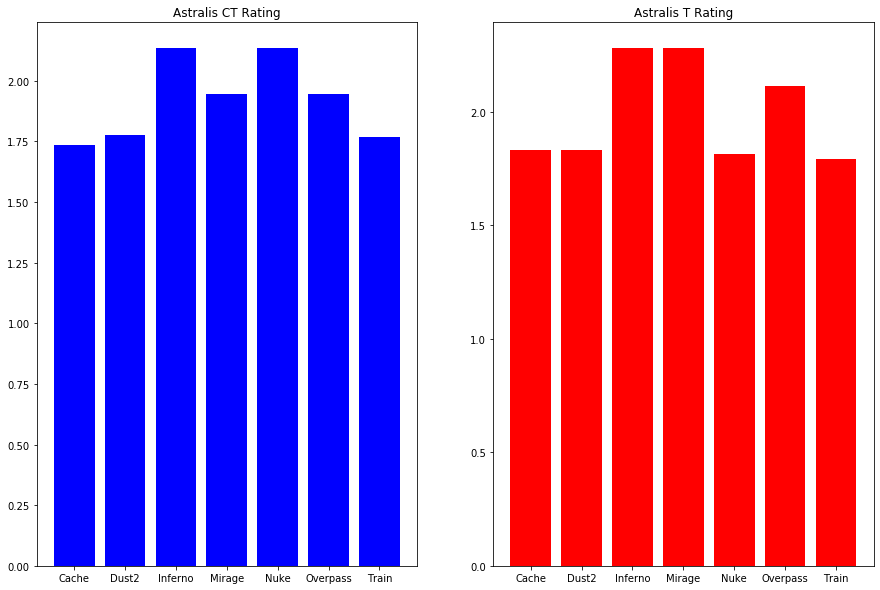

In [6]:
astralis_df = new_df.loc[new_df['Team'] == 'Astralis']
astralis_df = astralis_df.loc[astralis_df['MapWinner'] == 'Astralis']
astralis_df.reset_index(drop = True)
fig, (ax1, ax2) = plt.subplots(1,2,sharex = True, figsize = (15,10))
ax1.bar(x = astralis_df['Map'],height = astralis_df['Average_CT_Rating'], color = 'blue')
ax2.bar(x = astralis_df['Map'],height = astralis_df['Average_T_Rating'], color = 'red')

ax1.title.set_text('Astralis CT Rating')
ax2.title.set_text('Astralis T Rating')

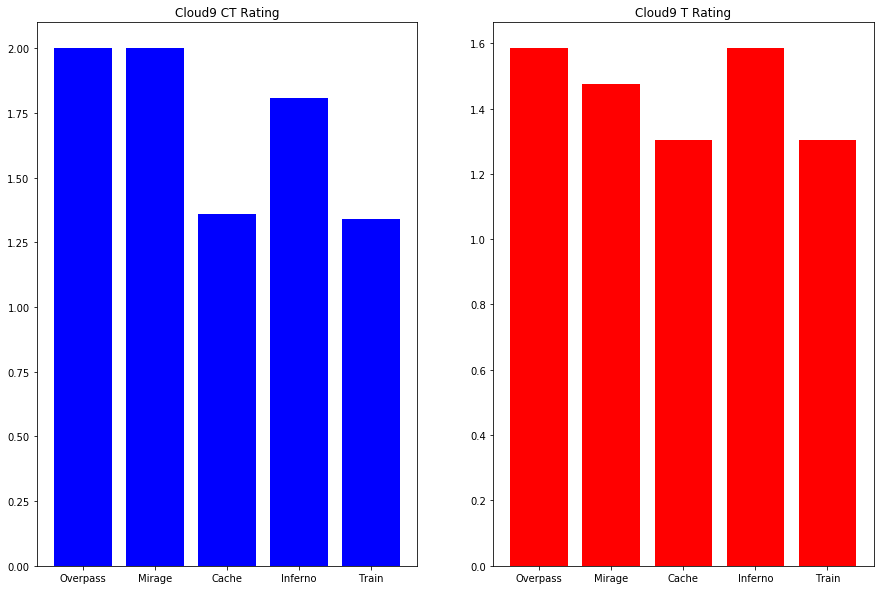

In [7]:
cloud9_df = new_df.loc[new_df['Team'] == 'Cloud9']
cloud9_df = cloud9_df.loc[cloud9_df['MapWinner'] == 'Cloud9']
cloud9_df.reset_index(drop = True)
fig, (ax1, ax2) = plt.subplots(1,2,sharex = True, figsize = (15,10))
ax1.bar(x = cloud9_df['Map'],height = cloud9_df['Average_CT_Rating'], color = 'blue')
ax2.bar(x = cloud9_df['Map'],height = cloud9_df['Average_T_Rating'], color = 'red')

ax1.title.set_text('Cloud9 CT Rating')
ax2.title.set_text('Cloud9 T Rating')

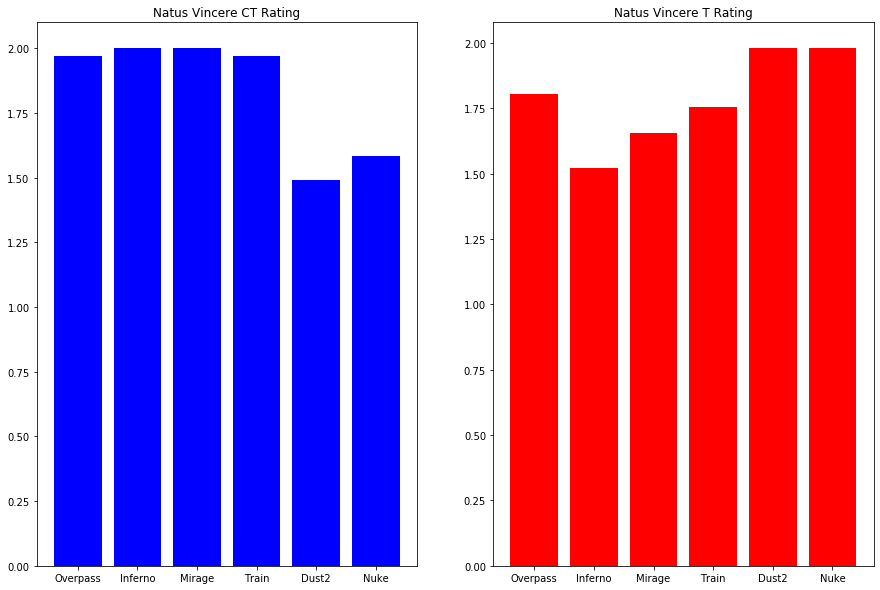

In [8]:
navi_df = new_df.loc[new_df['Team'] == 'Natus Vincere']
navi_df = navi_df.loc[navi_df['MapWinner'] == 'Natus Vincere']
navi_df.reset_index(drop = True)
fig, (ax1, ax2) = plt.subplots(1,2,sharex = True, figsize = (15,10))
ax1.bar(x = navi_df['Map'],height = navi_df['Average_CT_Rating'], color = 'blue')
ax2.bar(x = navi_df['Map'],height = navi_df['Average_T_Rating'], color = 'red')

ax1.title.set_text('Natus Vincere CT Rating')
ax2.title.set_text('Natus Vincere T Rating')

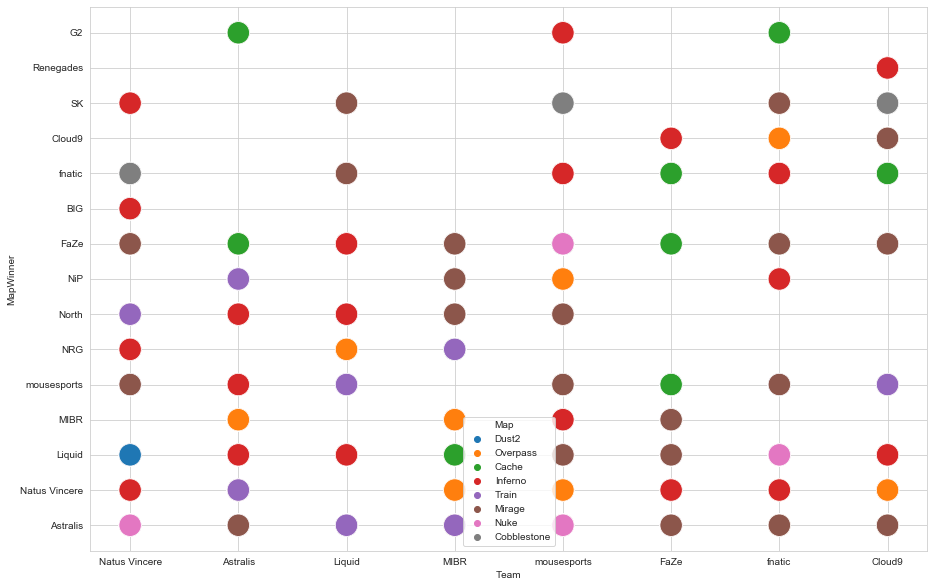

In [9]:
plt.figure(figsize=(15,10,))
sns.set_style("whitegrid")
temp_plt = sns.scatterplot(x='Team', y='MapWinner', hue='Map', data=new_df,s = 500)

## Predictive Models
___

Our coefficient for Astralis is [[0.24719536]]
Mean squared error: 0.09


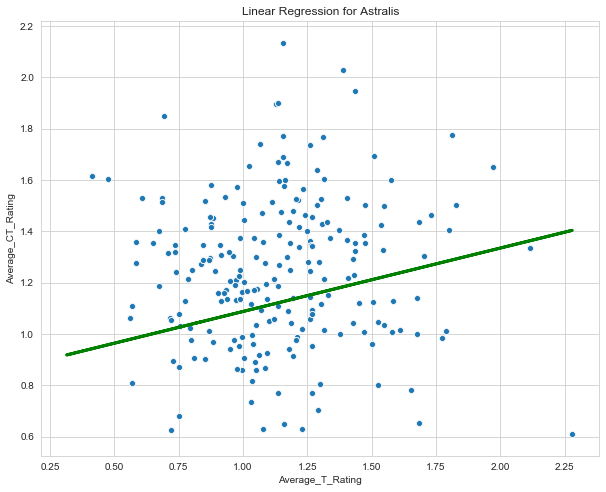

Our coefficient for Cloud9 is [[0.24719536]]
Mean squared error: 0.09


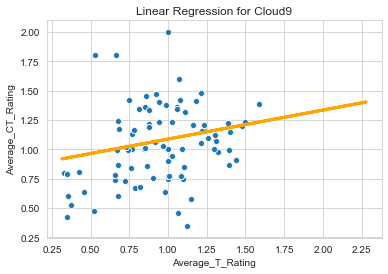

Our coefficient for FaZe is [[0.24719536]]
Mean squared error: 0.09


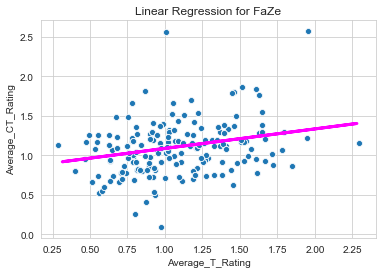

Our coefficient for Liquid is [[0.24719536]]
Mean squared error: 0.09


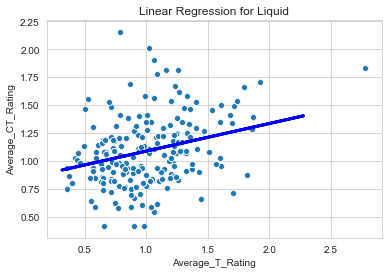

Our coefficient for MIBR is [[0.24719536]]
Mean squared error: 0.09


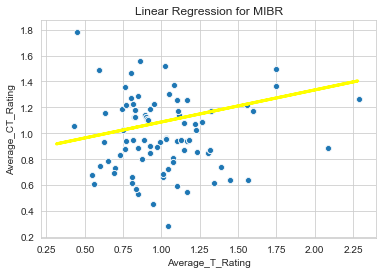

Our coefficient for Natus Vincere is [[0.24719536]]
Mean squared error: 0.09


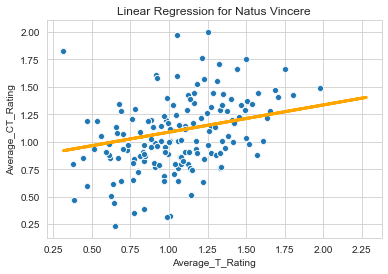

Our coefficient for fnatic is [[0.24719536]]
Mean squared error: 0.09


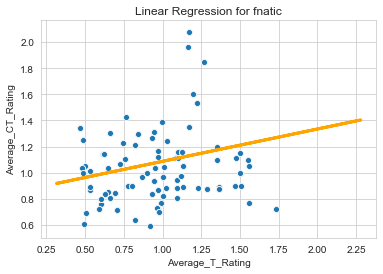

Our coefficient for mousesports is [[0.24719536]]
Mean squared error: 0.09


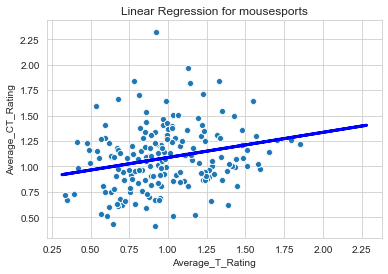

In [17]:
plt.figure(figsize=(10,8,))


# Creating a linear model by Team. 
for p_type, df in new_df.groupby('Team'):
    # Grab data grouped by Team. 
    sub_X = [[x] for x in new_df['Average_T_Rating'].values]
    sub_Xvals = [[x] for x in new_df['Average_CT_Rating'].values]
    # Graphing data. 
    sns.scatterplot(x='Average_T_Rating', y='Average_CT_Rating', data= new_df.loc[new_df['Team'].isin([p_type])])
    
    # Split up data using a 2/3 training set and a 1/3 test set. 
    x_train, x_test, y_train, y_test = train_test_split(sub_X, sub_Xvals, test_size=0.33, random_state=42)
    sub_lm= LinearRegression().fit(x_train, y_train)
    
    # Creating a linear regression model for each season. 
    prediction = sub_lm.predict(x_test)
    print("Our coefficient for", p_type, "is", sub_lm.coef_)
    print("Mean squared error: %.2f" % mean_squared_error(y_test, prediction))
    
    if(p_type=='Astralis'):
        plt.plot(x_test, prediction, linewidth=3,color = 'green', label = p_type)
    if(p_type=='Cloud9'):
        plt.plot(x_test, prediction, linewidth=3,color = 'orange', label = p_type)
    if(p_type=='SK'):
        plt.plot(x_test, prediction, linewidth=3,color = 'red', label = p_type)
    if(p_type=='FaZe'):
        plt.plot(x_test, prediction, linewidth=3,color = 'magenta', label = p_type)
    if(p_type=='G2'):
        plt.plot(x_test, prediction, linewidth=3,color = 'green', label = p_type)
    if(p_type=='Liquid'):
        plt.plot(x_test, prediction, linewidth=3,color = 'blue', label = p_type)
    if(p_type=='MIBR'):
        plt.plot(x_test, prediction, linewidth=3,color = 'yellow', label = p_type)
    if(p_type=='Natus Vincere'):
        plt.plot(x_test, prediction, linewidth=3,color = 'orange', label = p_type)
    if(p_type=='mousesports'):
        plt.plot(x_test, prediction, linewidth=3,color = 'blue', label = p_type)
    if(p_type=='fnatic'):
        plt.plot(x_test, prediction, linewidth=3,color = 'orange', label = p_type)
    plt.title('Linear Regression for ' + p_type)
    plt.show()

## Conclusion/Final Thoughts
___

## Sources

- [Kaggle CS:GO Professional Matches](https://www.kaggle.com/mateusdmachado/csgo-professional-matches)
- [Pandas Python Library](https://pandas.pydata.org/)
- [Beautiful Soup]([https://www.crummy.com/software/BeautifulSoup/bs4/doc/](https://www.crummy.com/software/BeautifulSoup/bs4/doc/))
